## Benchmark 6 revisit: linear models with structured bootstrap resampling
OK, so first round of linear model submissions to the public leaderboard produced some concerning results. TLDR: control resampling distribution seems to predict public leaderboard result well, linear models do not. Bootstrapping result look as if both Seigel and Theil-Sen regression will beat naive control with high probability, but both receive low scores that are extremely unlikely given their observed bootstrapped score distributions. What's going on? Let's try and find out - first thing is to check every step by manually inspecting output for sanity.

Note: this is version 2 of this notebook, version 1 was preserved in the state which produced the suspect results under investigation for reference.

While we are at it, let's start a major refactor here and move away from using notebooks for our main data generating logic and functions and instead use them just for plotting and discussion.

1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Results](#results)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

In [90]:
import sys
sys.path.append('..')
import config as conf

paths = conf.DataFilePaths()
params = conf.LinearModelsBootstrappingParameters()

import statistics
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statistics import NormalDist

<a name="results"></a>
### 2. Results

In [2]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,4,0.004149,0.007894,1.737230,1.758277,"[1.7518011, 1.7291347, 1.7161824, 1.7372298]","[0.014571300000000065, -0.022666400000000086, ...",1.744452
1,0,OLS,4,0.014453,0.000036,1.719420,1.744515,"[1.7518011, 1.7291347, 1.7161824, 1.7372298]","[0.014571300000000065, -0.022666400000000086, ...",1.744452
2,0,TS,4,0.019409,0.004820,1.710921,1.752880,"[1.7518011, 1.7291347, 1.7161824, 1.7372298]","[0.014571300000000065, -0.022666400000000086, ...",1.744452
3,0,Seigel,4,0.028676,0.006511,1.695135,1.755849,"[1.7518011, 1.7291347, 1.7161824, 1.7372298]","[0.014571300000000065, -0.022666400000000086, ...",1.744452
4,0,Ridge,4,0.013081,0.000660,1.721782,1.743301,"[1.7518011, 1.7291347, 1.7161824, 1.7372298]","[0.014571300000000065, -0.022666400000000086, ...",1.744452


In [3]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['SMAPE_values', 'detrended_SMAPE_values']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_values': 'SMAPE_score', 'detrended_SMAPE_values': 'detrended_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
0,0,OLS,4,2.639631,3.619305
1,0,OLS,8,3.129370,2.793972
2,0,OLS,16,9.318178,8.383948
3,0,OLS,32,4.705986,1.634116
4,0,Ridge,4,2.423133,3.228001


OK, let's take a look! Going to use a boxplot to look at the distribution of sample SMAPE scores across the different models and model orders. We also have fits to the raw and detrended data to look at. Keep in mind that the detrended fit was used to generate a raw MBD value for scoring purposes, so the underlying scale of the raw and detrended data panels are the same.

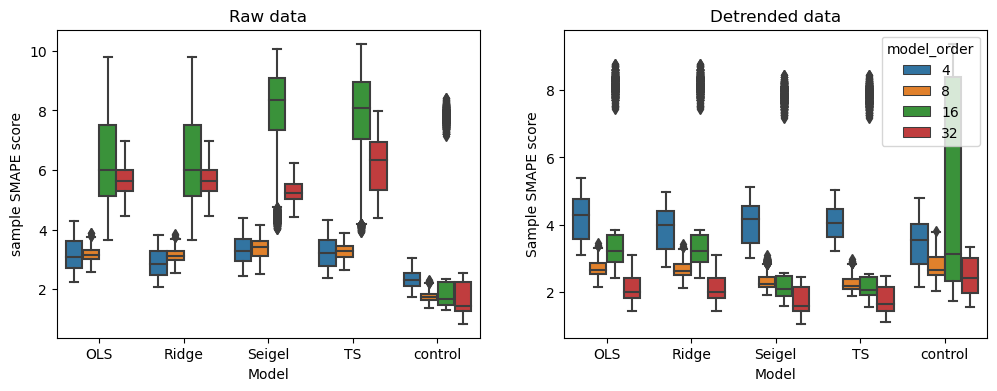

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='sample SMAPE score', 
    title='Raw data'
)
        # Collect detrended model forecast
ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample SMAPE score', 
    title='Detrended data'
)

plt.show()

Now, let's compare another way by plotting individual SMAPE values for all the datapoints in control vs regression.


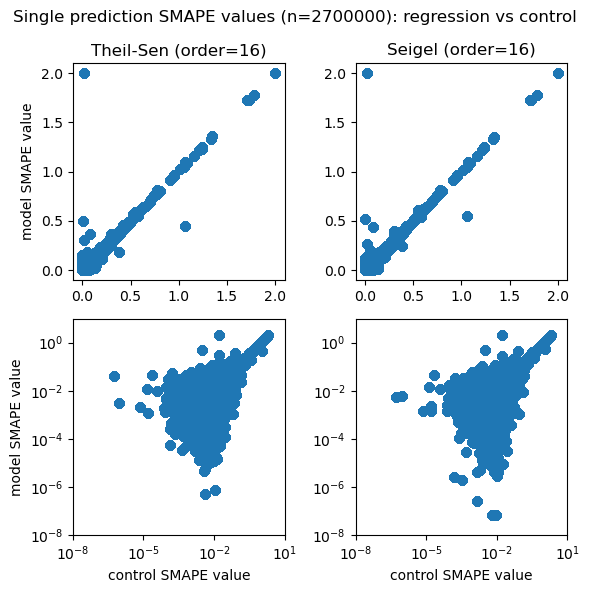

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[0,0].set_ylabel('model SMAPE value')
ax[0,0].set_title('Theil-Sen (order=16)')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[0,1].set_title('Seigel (order=16)')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('control SMAPE value')
ax[1,0].set_ylabel('model SMAPE value')
ax[1,0].set_xlim([10**-8,10])
ax[1,0].set_ylim([10**-8,10])

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('control SMAPE value')
ax[1,1].set_xlim([10**-8,10])
ax[1,1].set_ylim([10**-8,10])

n = len(data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): regression vs control')
plt.tight_layout()

Let's take a closer look at our winner(s).

In [6]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['SMAPE_score', 'detrended_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'SMAPE_score': 'mean_SMAPE_score', 'detrended_SMAPE_score': 'mean_detrended_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
0,OLS,4,3.151617,4.192100
1,OLS,8,3.171074,2.712544
2,OLS,16,6.459463,4.308775
3,OLS,32,5.657668,2.096321
4,Ridge,4,2.875603,3.870401


In [7]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
22500,0,control,32,0.007843,0.007782,2.002207,2.033738,"[1.5161086, 1.5476942, 1.5950726, 1.5476942, 1...","[0.11054949999999986, 0.0315856000000001, 0.04...",2.017972
22505,0,control,32,0.000000,0.000000,4.467766,4.467766,"[4.0900445, 4.2168674, 4.2802792, 4.2802792, 4...","[-0.19023469999999953, 0.12682289999999963, 0....",4.467766
22510,0,control,32,0.005373,0.005090,7.142569,7.140555,"[6.3970852, 6.4349141, 6.5324731, 6.500617, 6....","[-0.15330699999999986, 0.037828900000000054, 0...",7.104299


In [8]:
winner.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
22503,0,Seigel,32,0.028136,0.003905,2.075560,2.010107,"[1.5161086, 1.5476942, 1.5950726, 1.5476942, 1...","[0.11054949999999986, 0.0315856000000001, 0.04...",2.017972
22508,0,Seigel,32,0.014768,0.007026,4.534236,4.499266,"[4.0900445, 4.2168674, 4.2802792, 4.2802792, 4...","[-0.19023469999999953, 0.12682289999999963, 0....",4.467766
22513,0,Seigel,32,0.006638,0.008707,7.151613,7.166425,"[6.3970852, 6.4349141, 6.5324731, 6.500617, 6....","[-0.15330699999999986, 0.037828900000000054, 0...",7.104299


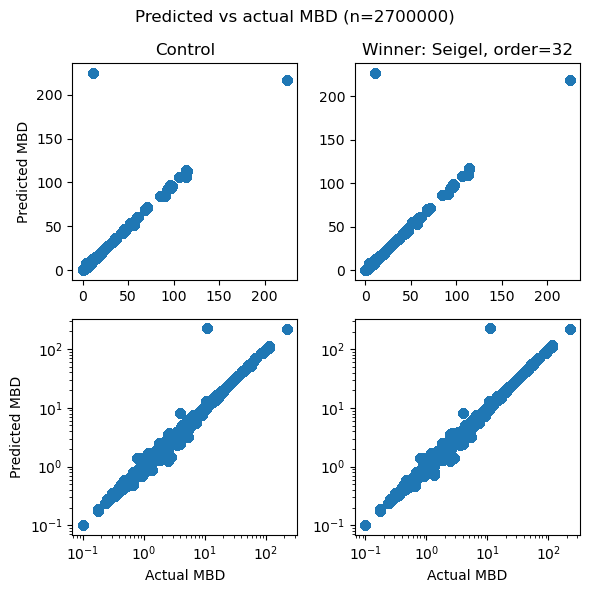

In [9]:
# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

ax[0,0].set_ylabel('Predicted MBD')
ax[0,0].set_title('Control')

ax[0,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

ax[0,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

ax[1,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions']
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('Actual MBD')
ax[1,0].set_ylabel('Predicted MBD')

ax[1,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('Actual MBD')

n = len(winner['MBD_actual'])
plt.suptitle(f'Predicted vs actual MBD (n={n})')
plt.tight_layout()

In [10]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['SMAPE_score'].describe()

count    1800.000000
mean        1.560499
std         0.527127
min         0.837323
25%         1.281039
50%         1.429484
75%         2.244259
max         2.545840
Name: SMAPE_score, dtype: float64

In [11]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_SMAPE_score'].describe()

count    1800.000000
mean        1.663051
std         0.407285
min         1.066130
25%         1.449429
50%         1.595711
75%         2.154826
max         2.462034
Name: detrended_SMAPE_score, dtype: float64

In [15]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_SMAPE_score'], control_sample_smape_scores['SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.3e}')

t-test p-value (H0: control mean = regression mean): 7.424e-11


In [18]:

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.4f}, {ci[1]:.3f}')

95% C.I. around difference in means: 0.0718, 0.133


In [19]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Mean: {smape_mean:.3f}')
print(f'Standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Mean: 1.663
Standard deviation: 0.4072

Probability of SMAPE <= 1.0936: 0.081
Probability of SMAPE > 1.0936: 0.919


OK, unfortunately - this is more like the answer we should be getting.The winning model performs worse than the control on average, but not by much.  The control and winning distributions are definitely different. The difference, though small, is highly statistically significant because of the large sample sizes involved.

Let's check the probabilities of the observed leaderboard results before we move on to try and improve the result.

In [20]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Winner mean: {smape_mean:.3f}')
print(f'Winner standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.2027)
print(f'Probability of model SMAPE <= 1.2027: {leaderboard_score_probability:.3f}')
print(f'Probability of model SMAPE > 1.2027: {1 - leaderboard_score_probability:.3f}')

Mean: 1.663
Standard deviation: 0.4072

Probability of model SMAPE <= 1.2027: 0.129
Probability of model SMAPE > 1.2027: 0.871


In [21]:
smape_mean = statistics.mean(control_sample_smape_scores['SMAPE_score'])
smape_std = statistics.pstdev(control_sample_smape_scores['SMAPE_score'])

print(f'Control mean: {smape_mean:.3f}')
print(f'Control standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of control SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of control SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Control mean: 1.560
Control standard deviation: 0.5270

Probability of control SMAPE <= 1.0936: 0.188
Probability of control SMAPE > 1.0936: 0.812


Interesting - both observed scores split the sampling distribution at approximately the same place. A pretty good showing on the leaderboard for both ~3 in 20 chance shot to do as well or better than observed for both.

Problem is, we are still loosing. On the bright side - we now can get a much better handle on the expected leaderboard results looking at our internal bootstrapping benchmark.

I am still tantalized by the observation that for some datapoints the control does well and the regression model does poorly, while for other points the control does poorly and the regression model does well. If we could pick the right model based on the input data alone, I think we could improve our score a bit - and figuring out a good way to do that would be generally useful. We could used a mixed bagging approach were we fit with several different models and pick or weight the best one. Now that we have the bootstrapping figured out, let's give it one more shot.

For reference, here is the specific plot I am referring to:

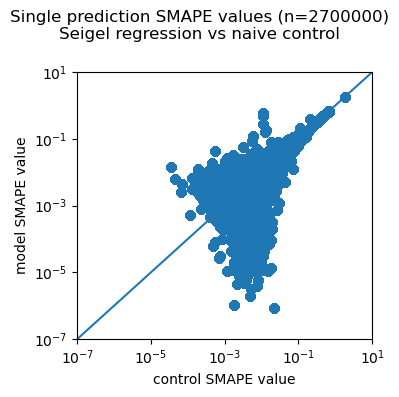

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 32)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)]['detrended_SMAPE_values']
)

ax.axline([0, 0], [1, 1])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('control SMAPE value')
ax.set_ylabel('model SMAPE value')
ax.set_xlim([10**-7,10])
ax.set_ylim([10**-7,10])


n = len(data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n})\nSeigel regression vs naive control')
plt.tight_layout()

Points along the y = x diagonal get a similar score with the control and regression models. Points above the diagonal score worse with the regression model than the control - in those cases we would rather take the control prediction. Points below the line score better with the regression model than the control - we would want to keep the regression value. Problem is, we need a way to classify points before we know their score, looking at the input data only. In notebook #11.1 we looked at the correlation of a bunch of one number 'summary' values derived from the input data with the SMAPE score and didn't find anything useful. I'm wondering if we should try looking at the difference between the model score and the control score and try to correlate that with some property of the input data. Let's get the score differences and just plot those to start with.  

In [159]:
model_data_df = data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)].copy()
model_data_df.reset_index(inplace = True, drop=True)

control_data_df = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 32)].copy()
control_data_df.reset_index(inplace=True, drop=True)

In [160]:
model_data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,Seigel,32,0.028136,0.003905,2.075560,2.010107,"[1.5161086, 1.5476942, 1.5950726, 1.5476942, 1...","[0.11054949999999986, 0.0315856000000001, 0.04...",2.017972
1,0,Seigel,32,0.014768,0.007026,4.534236,4.499266,"[4.0900445, 4.2168674, 4.2802792, 4.2802792, 4...","[-0.19023469999999953, 0.12682289999999963, 0....",4.467766
2,0,Seigel,32,0.006638,0.008707,7.151613,7.166425,"[6.3970852, 6.4349141, 6.5324731, 6.500617, 6....","[-0.15330699999999986, 0.037828900000000054, 0...",7.104299
3,0,Seigel,32,0.041847,0.008062,7.381685,7.759495,"[7.6199794, 7.6276126, 7.704638, 7.6838202, 7....","[0.23940370000000044, 0.007633199999999896, 0....",7.697192
4,0,Seigel,32,0.000956,0.002748,3.257606,3.251774,"[3.2510617, 3.237792, 3.3041401, 3.2908704, 3....","[0.013269700000000384, -0.013269700000000384, ...",3.260722


In [161]:
model_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700000 entries, 0 to 2699999
Data columns (total 10 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   sample                     int64  
 1   model_type                 object 
 2   model_order                int64  
 3   SMAPE_values               float64
 4   detrended_SMAPE_values     float64
 5   MBD_predictions            float64
 6   detrended_MBD_predictions  float64
 7   MBD_inputs                 object 
 8   detrended_MBD_inputs       object 
 9   MBD_actual                 float64
dtypes: float64(5), int64(2), object(3)
memory usage: 206.0+ MB


In [162]:
model_data_df['SMAPE_diff'] = (model_data_df['detrended_SMAPE_values'] - control_data_df['SMAPE_values']) / (control_data_df['SMAPE_values'] + model_data_df['detrended_SMAPE_values'])
model_data_df['prediction_diff'] = (model_data_df['detrended_MBD_predictions'] - control_data_df['MBD_predictions']) / (control_data_df['MBD_predictions'] + model_data_df['detrended_MBD_predictions'])
model_data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual,SMAPE_diff,prediction_diff
0,0,Seigel,32,0.028136,0.003905,2.075560,2.010107,"[1.5161086, 1.5476942, 1.5950726, 1.5476942, 1...","[0.11054949999999986, 0.0315856000000001, 0.04...",2.017972,-0.335190,0.001969
1,0,Seigel,32,0.014768,0.007026,4.534236,4.499266,"[4.0900445, 4.2168674, 4.2802792, 4.2802792, 4...","[-0.19023469999999953, 0.12682289999999963, 0....",4.467766,1.000000,0.003513
2,0,Seigel,32,0.006638,0.008707,7.151613,7.166425,"[6.3970852, 6.4349141, 6.5324731, 6.500617, 6....","[-0.15330699999999986, 0.037828900000000054, 0...",7.104299,0.236823,0.001667
3,0,Seigel,32,0.041847,0.008062,7.381685,7.759495,"[7.6199794, 7.6276126, 7.704638, 7.6838202, 7....","[0.23940370000000044, 0.007633199999999896, 0....",7.697192,0.499646,0.002686
4,0,Seigel,32,0.000956,0.002748,3.257606,3.251774,"[3.2510617, 3.237792, 3.3041401, 3.2908704, 3....","[0.013269700000000384, -0.013269700000000384, ...",3.260722,-0.204162,0.000705


In [163]:
model_data_df['SMAPE_diff'].describe()

count    2.562768e+06
mean     7.375550e-02
std      3.878825e-01
min     -9.999229e-01
25%     -9.644604e-02
50%      1.059966e-03
75%      2.277709e-01
max      1.000000e+00
Name: SMAPE_diff, dtype: float64

In [164]:
model_data_df['prediction_diff'].describe()

count    2.699172e+06
mean     7.698705e-04
std      5.781973e-03
min     -3.024856e-01
25%     -5.723689e-05
50%      6.253156e-04
75%      2.316983e-03
max      8.576221e-02
Name: prediction_diff, dtype: float64

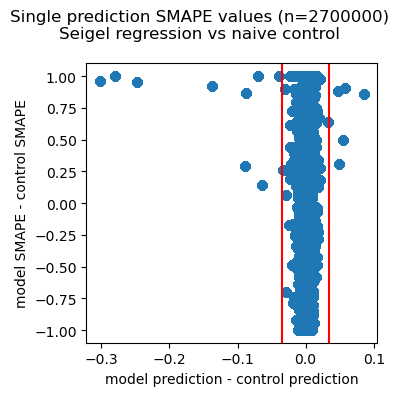

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    model_data_df['prediction_diff'],
    model_data_df['SMAPE_diff']
)

ax.axline([-0.035,-1.00], [-0.035,1.00], color='red')
ax.axline([0.035,-1.00], [0.035,1.00], color='red')

ax.set_xlabel('model prediction - control prediction')
ax.set_ylabel('model SMAPE - control SMAPE')

#ax.set_xscale('log', base=2)

n = len(data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n})\nSeigel regression vs naive control')
plt.tight_layout()

Ok, I think we might be on to something: if model - control SMAPE value is positive then the model SMAPE was higher (worse) than the control - so the top half of the plot. For model - control prediction < -0.035 and > 0.035, all of the points are in the top half! This means that if the difference in the result we get from the control and the model is outside of those bounds, we will do better taking the control value. Don't get to excited - it looks like it may be a pretty small fraction of the total points, but it's something. Let's add some bounding lines ot the plot for illustrative purposes and then see how many points we are talking about.

Also, does it seem like a strange coincidence that the upper and lower bounds occur at about the same value? I wonder if we could move the limits in a bit and still benefit, even though we might start tossing some 'good' points out with the bath water.

In [180]:
control_wins = model_data_df[(model_data_df['prediction_diff'] <= -0.035) | (model_data_df['prediction_diff'] >= 0.35)].copy()
print(f'{(len(control_wins) / len(model_data_df)) * 100:.3f}% of predictions out-of-bounds.')

0.071% of predictions out-of-bounds.


OK, so like I thought - tiny. Not sure if it would have any noticeable effect on the total score, but it couldn't hurt to fix some of our worst performing points. Let's try a few other things before we pack it up. Here comes the kitchen sink...

In [186]:
import statistics

data_ranges = []
SMAPE_values = []
SMAPE_diff_values = []
theil_slopes = []
total_fit_residuals = []
mean_fit_residuals = []
total_residuals_as_fraction_of_range = []
mean_residuals_as_fraction_of_range = []
slope_range = []
input_variance = []
input_deviation = []
input_absolute_sum = []

for i in range(len(model_data_df)):

    # Get data for this row
    data_point = model_data_df.iloc[[i]]
    input_data = list(data_point['detrended_MBD_inputs'])[0]
    SMAPE_value = list(data_point['detrended_SMAPE_values'])[0]
    SMAPE_diff_value = list(data_point['SMAPE_diff'])[0]
    data_range = max(input_data) - min(input_data)

    if data_range != 0:

        # Collect absolute input sum
        absolute_sum = 0
        
        for data in input_data:
            absolute_sum += abs(data)

        input_absolute_sum.append(absolute_sum)

        # Collect input variance
        input_variance.append(statistics.variance(input_data))

        # Collect input standard deviation
        input_deviation.append(statistics.stdev(input_data))

        # Collect input data range
        data_ranges.append(data_range)

        # Collect SMAPE value
        SMAPE_values.append(SMAPE_value)
        SMAPE_diff_values.append(SMAPE_diff_value)

        # Fit Theil-Sen
        ts = stats.theilslopes(input_data, list(range(len(input_data))))

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Collect slope
        theil_slopes.append(slope)

        # Collect slope range
        slope_range.append(ts[3] - ts[2])
        
        residuals = 0

        # Sum fit residuals
        for input in input_data:
            model_y = intercept + slope * input
            residuals += abs(model_y - input)

        total_fit_residuals.append(residuals)
        mean_fit_residuals.append(residuals / len(input_data))

        total_residuals_as_fraction_of_range.append(residuals / data_range)
        mean_residuals_as_fraction_of_range.append((residuals / len(input_data)) / data_range)

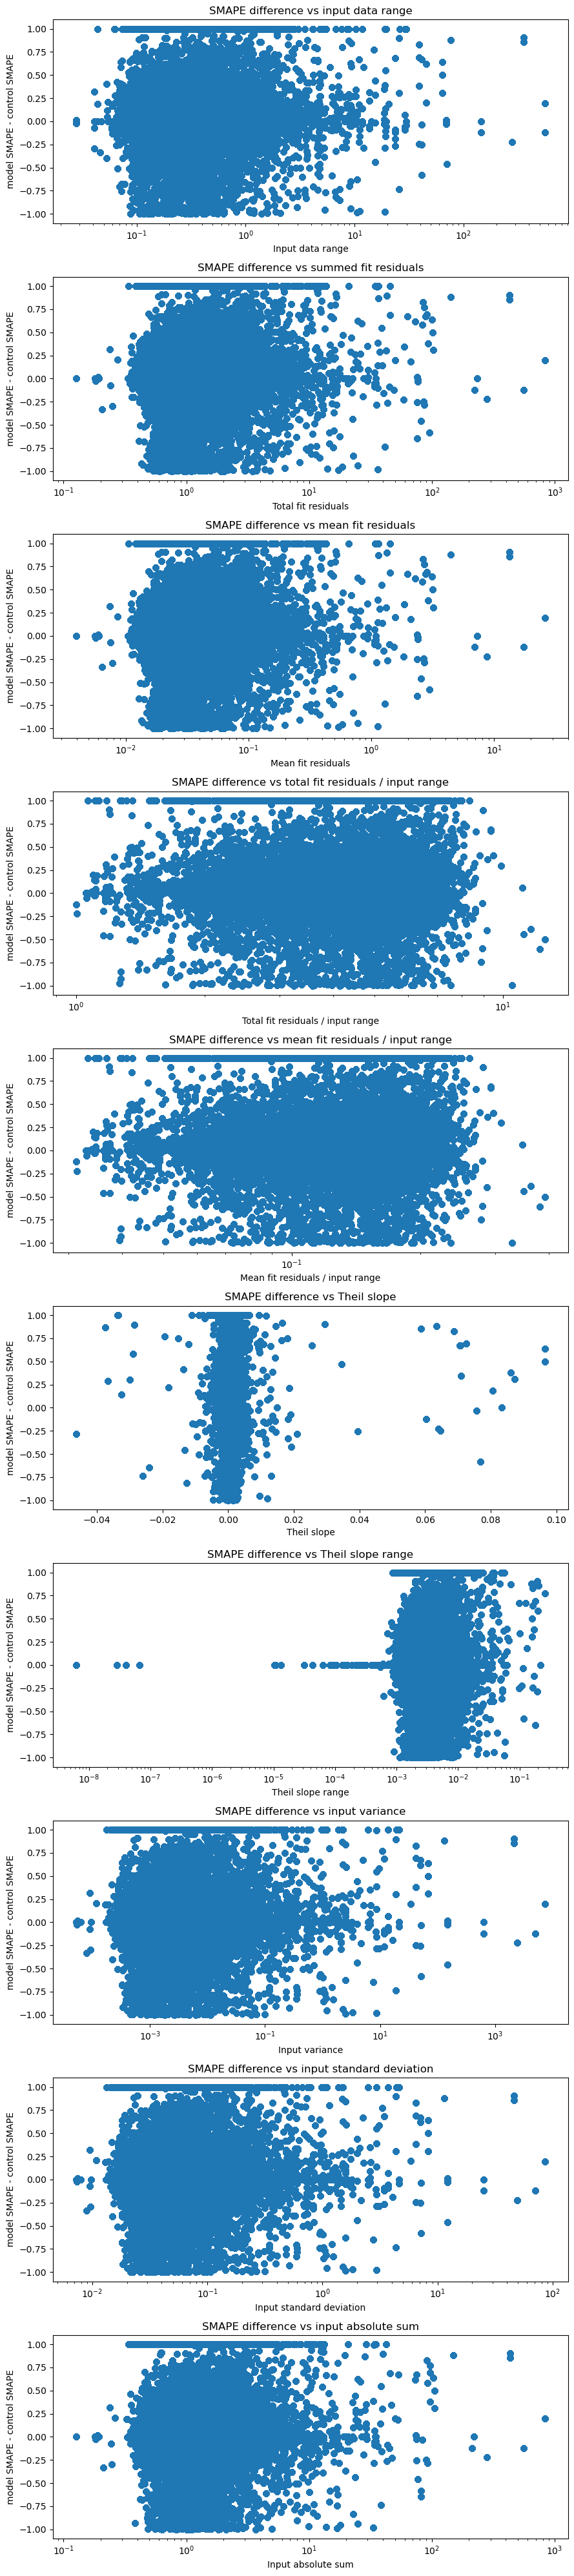

In [193]:
fig, ax = plt.subplots(10, 1, figsize=(9,40))

ax[0].scatter(
    data_ranges,
    SMAPE_diff_values
)
ax[0].set_xlabel('Input data range')
ax[0].set_ylabel('model SMAPE - control SMAPE')
ax[0].title.set_text('SMAPE difference vs input data range')
ax[0].set_xscale('log', base=10)

ax[1].scatter(
    total_fit_residuals,
    SMAPE_diff_values
)
ax[1].set_xlabel(f'Total fit residuals')
ax[1].set_ylabel(f'model SMAPE - control SMAPE')
ax[1].title.set_text('SMAPE difference vs summed fit residuals')
ax[1].set_xscale('log', base=10)

ax[2].scatter(
    mean_fit_residuals,
    SMAPE_diff_values
)
ax[2].set_xlabel(f'Mean fit residuals')
ax[2].set_ylabel(f'model SMAPE - control SMAPE')
ax[2].title.set_text('SMAPE difference vs mean fit residuals')
ax[2].set_xscale('log', base=10)

ax[3].scatter(
    total_residuals_as_fraction_of_range,
    SMAPE_diff_values
)
ax[3].set_xlabel(f'Total fit residuals / input range')
ax[3].set_ylabel(f'model SMAPE - control SMAPE')
ax[3].title.set_text('SMAPE difference vs total fit residuals / input range')
ax[3].set_xscale('log', base=10)

ax[4].scatter(
    mean_residuals_as_fraction_of_range,
    SMAPE_diff_values
)
ax[4].set_xlabel(f'Mean fit residuals / input range')
ax[4].set_ylabel(f'model SMAPE - control SMAPE')
ax[4].title.set_text('SMAPE difference vs mean fit residuals / input range')
ax[4].set_xscale('log', base=10)

ax[5].scatter(
    theil_slopes,
    SMAPE_diff_values
)
ax[5].set_xlabel(f'Theil slope')
ax[5].set_ylabel(f'model SMAPE - control SMAPE')
ax[5].title.set_text('SMAPE difference vs Theil slope')
ax[3].set_xscale('log', base=10)

ax[6].scatter(
    slope_range,
    SMAPE_diff_values
)
ax[6].set_xlabel(f'Theil slope range')
ax[6].set_ylabel(f'model SMAPE - control SMAPE')
ax[6].title.set_text('SMAPE difference vs Theil slope range')
ax[6].set_xscale('log', base=10)

ax[7].scatter(
    input_variance,
    SMAPE_diff_values
)
ax[7].set_xlabel(f'Input variance')
ax[7].set_ylabel(f'model SMAPE - control SMAPE')
ax[7].title.set_text('SMAPE difference vs input variance')
ax[7].set_xscale('log', base=10)

ax[8].scatter(
    input_deviation,
    SMAPE_diff_values
)
ax[8].set_xlabel(f'Input standard deviation')
ax[8].set_ylabel(f'model SMAPE - control SMAPE')
ax[8].title.set_text('SMAPE difference vs input standard deviation')
ax[8].set_xscale('log', base=10)

ax[9].scatter(
    input_absolute_sum,
    SMAPE_diff_values
)
ax[9].set_xlabel(f'Input absolute sum')
ax[9].set_ylabel(f'model SMAPE - control SMAPE')
ax[9].title.set_text('SMAPE difference vs input absolute sum')
ax[9].set_xscale('log', base=10)

#plt.suptitle('Predicted vs actual MBD\nwinning regression model and control')
#plt.setp(ax, xlim=(-5,100), ylim=(-0.05,0.6))
plt.tight_layout()

OK, so in many of the above plots there is a line of points crowded at the top edge where model - control SMAPE = 1. To arrive at this value, the control SMAPE must have been zero, then the fraction used to normalize the SMAPE difference simplifies to model SMAPE / model SMAPE = 1. There MUST be some way to identify these points. Let's see if we can recover them. If we could take the control prediction in theses cases, we could probably improve our score significantly.

In [194]:
control_wins = model_data_df[model_data_df['SMAPE_diff'] == 1].copy()
print(f'{(len(control_wins) / len(model_data_df)) * 100:.3f}% of predictions have SMAPE diff = 1.0')

6.187% of predictions out-of-bounds.


This is on the order of 100x more data points than our last best idea. Let's go after it. Going to try just plotting the data to see if I can get and idea of what is going on to cause a bad regression fit, but a perfect control result.

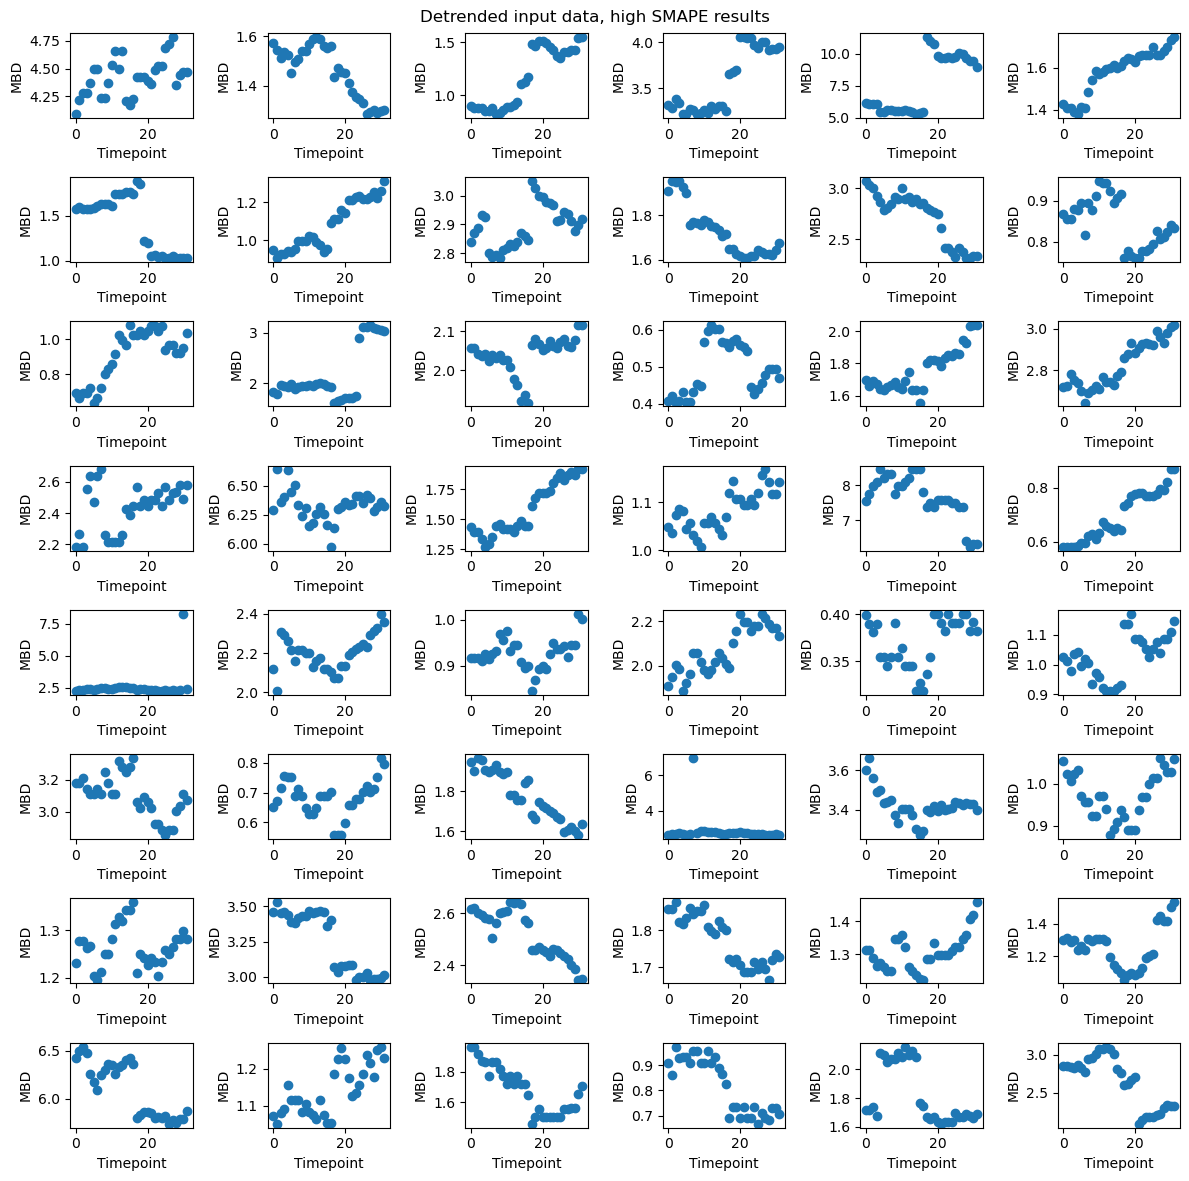

In [200]:
plot_rows = 8
plot_cols = 6
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = control_wins.iloc[[plot_num]]
        MBD_values = list(data_point['MBD_inputs'])[0]

        ax[i,j].scatter(
            list(range(len(MBD_values))),
            MBD_values
        )
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Detrended input data, high SMAPE results')
#plt.setp(ax, xlim=(-10,210), ylim=(-10,210))
plt.tight_layout()

Nothing jumps out as to why the control seems to nail it - only thing I can say there is it must be luck. One idea it does give me though: let's try looking at just the last fit residual. The regression is looking at all of the data, and many of these look like the line is probably pretty off the mark at the right edge of the plot.

In [204]:
SMAPE_diff_values = []
last_fit_residual = []
last_fit_residual_fraction = []

for i in range(len(model_data_df)):

    # Get data for this row
    data_point = model_data_df.iloc[[i]]
    input_data = list(data_point['detrended_MBD_inputs'])[0]
    SMAPE_diff_value = list(data_point['SMAPE_diff'])[0]

    if input_data[-1] != 0:

        # Get SMAPE difference value
        SMAPE_diff_values.append(SMAPE_diff_value)

        # Fit Theil-Sen
        ts = stats.theilslopes(input_data, list(range(len(input_data))))

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Get fit residual for last input point
        model_y = intercept + slope * input_data[-1]
        residual = abs(model_y - input_data[-1])

        last_fit_residual.append(residual)
        last_fit_residual_fraction.append(residual / input_data[-1])